In [3]:
from helikite import Cleaner, instruments
import os
import datetime

cleaner = Cleaner(
    instruments=[
        instruments.flight_computer_v2,
        instruments.smart_tether,
        # instruments.pops,
        instruments.msems_readings,
        instruments.msems_inverted,
        instruments.msems_scan,
        # instruments.stap,
    ], 
    reference_instrument=instruments.flight_computer_v2,
    input_folder=os.path.join(os.getcwd(), os.pardir, "helikite", "tests", "resources", "campaigns", "20250212"),
    flight_date=datetime.date(2025,2,12),
    # time_takeoff=datetime.datetime(2024,4,2,10,0,35),
    # time_landing=datetime.datetime(2024,4,2,13,4,4),
    time_offset=datetime.time(0),
)



2025-03-14 10:31:54,408 [INFO   ] mSEMS Inverted file detected at header 55


Helikite Cleaner has been initialised with 5 instruments. Use the .state() method to see the current state, and the .help() method to see the available methods.


In [4]:
cleaner.set_time_as_index()
cleaner.data_corrections()
cleaner.set_pressure_column()


Set time as index for (5/5): flight_computer, smart_tether, msems_readings, msems_inverted, msems_scan
Errors (0/5):
Set data corrections for (5/5): flight_computer, smart_tether, msems_readings, msems_inverted, msems_scan
Errors (0/5):
Set pressure column for (5/5): flight_computer, smart_tether, msems_readings, msems_inverted, msems_scan
Errors (0/5):


In [5]:
cleaner.define_flight_times()

Note: msems_inverted does not have a pressure column


    'data': [{'line': {'color': 'red', 'width': 2},
              'name': 'fligh…

In [6]:
cleaner.correct_time_and_pressure(max_lag=180)

Cross correlation:
	Working on instrument: flight_computer
	Skipping reference instrument

	Working on instrument: smart_tether
	Instrument: smart_tether | Max val 0.9999901660900874 @ idx: -10
	Shifting smart_tether_ by -10 index

	Working on instrument: msems_readings
	Instrument: msems_readings | Max val 0.9997715952881805 @ idx: 25
	Shifting msems_readings_ by 25 index

	Working on instrument: msems_inverted
	ERROR: No pressure column in msems_inverted

	Working on instrument: msems_scan
	Instrument: msems_scan | Max val 0.9959580300373054 @ idx: 33
	Shifting msems_scan_ by 33 index

Time and pressure corrections applied.
Note: Cross correlation df available at Cleaner.df_corr
Note: Pressure data available at Cleaner.df_pressure


In [7]:


cleaner.remove_duplicates()
cleaner.merge_instruments()
cleaner.export_data()

2025-03-14 10:35:28,376 [INFO   ] Duplicates removed from flight_computer: 0
2025-03-14 10:35:28,385 [INFO   ] Duplicates removed from smart_tether: 0
2025-03-14 10:35:28,395 [INFO   ] Duplicates removed from msems_readings: 0
2025-03-14 10:35:28,417 [INFO   ] Duplicates removed from msems_inverted: 0
2025-03-14 10:35:28,447 [INFO   ] Duplicates removed from msems_scan: 0


Set duplicate removal for (5/5): flight_computer, smart_tether, msems_readings, msems_inverted, msems_scan
Errors (0/5):
Using merge_asof to align and merge instrument dataframes.
Master dataframe created using merge_asof. Available at Cleaner.master_df.

Done. The file 'level0_2025-02-12T07-55'.{csv|parquet} contains all instrument data. The metadata is stored in the Parquet file.


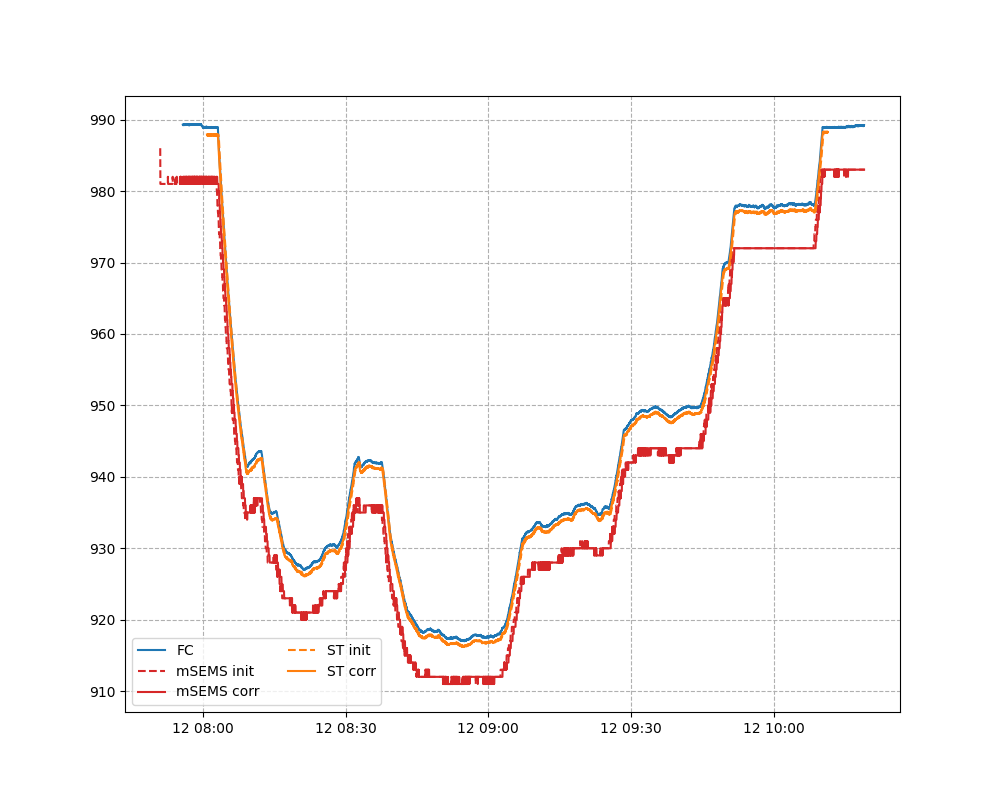

In [8]:
import matplotlib
import numpy as np
import matplotlib.colors as mcols
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates

%matplotlib ipympl
# Plot the corr_df for each instrument on one plot
fig, (ax) = plt.subplots(1,1, figsize=(10,8))
ax.plot(cleaner.flight_computer.df.index,cleaner.flight_computer.df['pressure'],label='FC',color='C0')

ax.plot(cleaner.msems_readings.df_before_timeshift.index,cleaner.msems_readings.df_before_timeshift['pressure'],linestyle='dashed',color='C3',label='mSEMS init')
ax.plot(cleaner.msems_readings.df.index,cleaner.msems_readings.df['pressure'],color='C3',label='mSEMS corr')

ax.plot(cleaner.smart_tether.df_before_timeshift.index,cleaner.smart_tether.df_before_timeshift['pressure'],linestyle='dashed',color='C1',label='ST init')
ax.plot(cleaner.smart_tether.df.index,cleaner.smart_tether.df['pressure'],label='ST corr',color='C1')
ax.grid(ls='--')
ax.legend(ncols=2)
# plt.savefig(figurefolder+'\\pressures_corr_FL'+datefolder[2:]+'.png')